Overview of the problem to solve with this model
- Intially train a simple model off few features utilizing a training pipeline to predict patients who 1) are septic or 2) at-risk of becoming septic
- Develop heuristics to filter out patients who are septic to avoid costs for model inferencing
- Train more complex models to infer patients at-risk of becoming septic based on more complex data sources and features

Overview of Sepsis Indicators:

**bold indicates availability from our data**

Sepsis - Systemic inflammatory response syndrome (SIRS) 2 or more are met:
1. **Body temperature > 38.5°C or < 35.0°C**
1. **Heart rate > 90 beats per minute**
1. **Respiratory rate > 20 breaths per minute or arterial CO2 tension < 32 mm Hg or need for mechanical ventilation**
1. **White blood cell count > 12,000/mm3 or < 4,000/mm3 or immature forms > 10%**

Severe sepsis - Sepsis and at least one sign of organ hypoperfusion or organ dysfunction:
1. Areas of mottled skin
1. Capillary refilling time ≥ 3 s
1. Urinary output < 0.5 mL/kg for at least 1 h or renal replacement therapy
1. **Lactates > 2 mmol/L**
1. Abrupt change in mental status or abnormal electroencephalogram
1. **Platelet counts < 100,000/mL or disseminated intravascular coagulation**
1. Acute lung injury—acute respiratory distress syndrome
1. Cardiac dysfunction (echocardiography) 

Septic shock - Severe sepsis and one of:
1. Systemic mean blood pressure of < 60 mm Hg (< 80 mm Hg if previous hypertension) after 20–30 mL/kg starch or 40–60 mL/kg serum saline, or pulmonary capillary wedge pressure between 12 and 20 mm Hg
1. Need for dopamine > 5 μg/kg per min or norepinephrine or epinephrine < 0.25 μg/kg per min to maintain mean blood pressure above 60 mm Hg (> 80 mm Hg if previous hypertension) ### Refractory septic shock
1. Need for dopamine > 15 μg/kg per min or norepinephrine or epinephrine > 0.25 μg/kg per min to maintain mean blood pressure above 60 mm Hg (> 80 mm Hg if previous hypertension)

Overview of this projects current goal for the Data Engineering
- use only the Patient Vital signs (pat_vitals_labeled-dataSepsis.csv) to indentify predictive signals (columns) 
- generate a data preprocessing pipeline for feeding data to the model

Overview of the data for this project
- Data was originally based on a Kaggle project https://www.kaggle.com/maxskoryk/datasepsishttps://www.kaggle.com/maxskoryk/datasepsis
- Major changes were made due to the data bias for demographics influencing sepsis indicator AND the sepsis indicators were not accurate
- Patient ID, record date and record time were added 
- HR, Temp and RR were generated to accurately reflect values and patient percentage representation in the believed real world
- Data was split into 3 separate labeled data files
    - Patient Demographics (pat_demog_labeled_dataSepsis.csv)
    - Patient Laboratory Values (pat_labs_labeled_dataSepsis.csv)
    - Patient Vital Signs (pat_vitals_labeled_dataSepsis.csv)

Overview of steps in the notebook Overview of steps in the notebook
- Fetch and write the data for updates using urllib, zipfile, and os for OS agnostic handling
- Load the data as a Dataframe using Pandas
- Explore the Dataframe with Pandas
- Split the data into train and test sets with Scikit-Learn
- Visualize the train data with Matplotlib and Seaborn
- Explore correlation among features
- Feature down selection

Import Packages

In [1]:
# data ingestion
import urllib.request
import os
import zipfile

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Add directory above current directory to path
import sys; sys.path.insert(0, '..')

# possible removeable of submodules
#from submodules.fetch_data import fetch_data
#from submodules.load_data import load_data

from pandas.plotting import scatter_matrix
from IPython.display import Image


# data splitting
from sklearn.model_selection import train_test_split

Fetch the data

In [2]:
# fetch the data using a python function, commented out b/c cannot use with Kaggle source
#fetch_data()

Load the data

In [3]:
# load the data using a python function
#data = load_data()

# without using a python function
# set for the Signal definitions
attr_path = "../../data/dataSepsis/csv_format/attribute_definitions.csv"
attr = pd.read_csv(attr_path, sep=",")
# set for the Patient Vital Signs
csv_path = "../../data/dataSepsis/csv_format/pat_vitals_labeled-dataSepsis.csv"
data = pd.read_csv(csv_path, sep=",")

Review of Signal Definitions available from the data source

In [4]:
# list the attributes definition file for the Patient Vital Signs
attr.head(13)

,target_file,attribute_name,attribute_definition
0,NaN,List all the attributes in the dataset. Label ...,NaN
1,NaN,NaN,NaN
2,pat_vitals_labeled.csv,Vital signs (columns 1-8),"Doctors order, basis every 4 hours, least inva..."
3,pat_vitals_labeled.csv,HR,Heart rate (beats per minute)
4,pat_vitals_labeled.csv,O2Sat,Pulse oximetry (%)
5,pat_vitals_labeled.csv,Temp,Temperature (Deg C)
6,pat_vitals_labeled.csv,SBP,Systolic BP (mm Hg)
7,pat_vitals_labeled.csv,MAP,Mean arterial pressure (mm Hg)
8,pat_vitals_labeled.csv,DBP,Diastolic BP (mm Hg)
9,pat_vitals_labeled.csv,Resp,Respiration rate (breaths per minute)


First glance of raw data. First 10 rows.

In [5]:
data.head(10)

,patient_id,record_date,record_time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,isSepsis
0,1,NaN,NaN,63,90.0,40.30,NaN,NaN,NaN,17,NaN,0
1,2,NaN,NaN,79,95.0,39.20,143.0,77.0,47.0,13,NaN,0
2,3,NaN,NaN,87,94.0,40.30,133.0,74.0,48.0,20,NaN,0
3,4,NaN,NaN,71,100.0,42.10,NaN,NaN,NaN,15,NaN,0
4,5,NaN,NaN,68,94.5,39.70,147.5,102.0,NaN,20,NaN,0
5,6,NaN,NaN,78,99.0,39.60,100.0,67.0,49.5,18,NaN,0
6,7,NaN,NaN,242,NaN,39.30,NaN,NaN,NaN,33,NaN,1
7,8,NaN,NaN,81,100.0,40.30,112.0,79.5,63.0,18,NaN,0
8,9,NaN,NaN,178,100.0,39.22,141.0,85.0,57.0,22,NaN,1
9,10,NaN,NaN,81,95.0,39.20,121.0,20.0,NaN,17,NaN,0


What types of columns and data do we have?
1. are we missing any records? 
1. are we missing entries? 
1. do we have any categorical data?
If yes for any above questions, plan to collect, drop, or convert.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36302 entries, 0 to 36301
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient_id   36302 non-null  int64  
 1   record_date  0 non-null      float64
 2   record_time  0 non-null      float64
 3   HR           36302 non-null  int64  
 4   O2Sat        34736 non-null  float64
 5   Temp         36302 non-null  float64
 6   SBP          34617 non-null  float64
 7   MAP          34846 non-null  float64
 8   DBP          27917 non-null  float64
 9   Resp         36302 non-null  int64  
 10  EtCO2        1613 non-null   float64
 11  isSepsis     36302 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 3.3 MB


In [11]:
data.count(axis=0).sort_values(ascending=True)

record_date        0
record_time        0
EtCO2           1613
DBP            27917
SBP            34617
O2Sat          34736
MAP            34846
patient_id     36302
HR             36302
Temp           36302
Resp           36302
isSepsis       36302
dtype: int64

Forward Action
1. drop record_date
1. drop record_time
1. drop EtCO2

What does calculus expose about the data?

Average (mean), minimum (min), maximum (max) are self-explanatory

Standard deviation (std) how dispersed the values are
- normal (Gaussian) distribution follows 68-95-99.7 rule
- % of values are within 1 std
- % of values are within 2 std
- % of values are within 3 std

1st (25%), median (50%), 3rd (75%) quartiles or percentiles, for example:
- % of the patients had a temp lower than 36.3°C
- % of the patients had a resp higher than 20.5 breaths per minute

In [13]:
data.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
patient_id,36302.0,18151.500000,10479.629073,1.0,9076.25,18151.5,27226.75,36302.0
record_date,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
record_time,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HR,36302.0,80.630131,26.527839,60.0,68.00,76.0,84.00,250.0
O2Sat,34736.0,97.444337,2.827282,27.0,96.00,98.0,100.00,100.0
Temp,36302.0,37.430816,1.312797,35.0,36.60,37.2,37.90,42.3
SBP,34617.0,122.625064,23.092558,32.0,106.00,120.0,137.00,281.0
MAP,34846.0,82.263649,16.876642,20.0,71.00,80.0,91.33,291.0
DBP,27917.0,63.793506,14.130816,22.0,54.00,62.0,72.00,281.0
Resp,36302.0,18.001543,5.154509,12.0,14.00,17.0,19.00,35.0


Forward Action
1. Scale remaining signals between 0 and 1

Are Sepsis patient entries representative of the real world? A common split is:
- 93% of patients are not septic
- 7% of patients are septic

In [14]:
data["isSepsis"].value_counts(normalize=True).to_frame()

,isSepsis
0,0.927084
1,0.072916


Create a Test Dataset

- Performing this early minimizes generalization and bias you may inadvertently apply to your system. 
- A test set of data involves: picking ~(10, 15, or 20)% of the instances randomly and setting them aside.
- you never want your model to see the entire dataset
- you should plab to fetch new data for training
- you want to maintain the same percentage of training data against the entire dataset
- you want a representative training dataset (~7% septic positive)

In [16]:
X_train, X_test, y_train, y_test = \
    train_test_split(data.drop("isSepsis", axis=1),
                     data["isSepsis"], test_size=0.15,
                     random_state=42, stratify=data["isSepsis"])

print("Training data: ", X_train.shape)
print("Training labels: ", y_train.shape)

print("Testing data: ", X_test.shape)
print("Testing labels: ", y_test.shape)

Training data:  (30856, 11)
Training labels:  (30856,)
Testing data:  (5446, 11)
Testing labels:  (5446,)


Plot the non-septic (0) vs. septic (1) patient records to identify clear distinctions?

In [19]:
vitals = ["HR", # Heart Rate normal adult 60 - 100 beats per minute (bpm)
          'O2Sat', # Oxygen saturation normal adult 97% - 100% (%)
          'Temp', # Temperature normal 97.8°F/36.5°C - 99°F/37.2°C (°C)
          'SBP', # Systolic Blood Pressure normal < 120 mmHg (mm Hg) (indicates how much pressure your blood is exerting against your artery walls when the heart beats.)
          'DBP', # beclomethasone dipropionate normal < 80 mmHg (mm Hg) (indicates how much pressure your blood is exerting against your artery walls while the heart is resting between beats.)
          'MAP', # Mean Arterial Pressure (mm Hg)
          'Resp', # Respiration rate  12<normal<20 breaths / minute (bpm)
          "EtCO2" # End-tidal CO2 maximum concentration of CO2 at exhalation normal 35 - 45 mmHg (mm Hg)
          ]

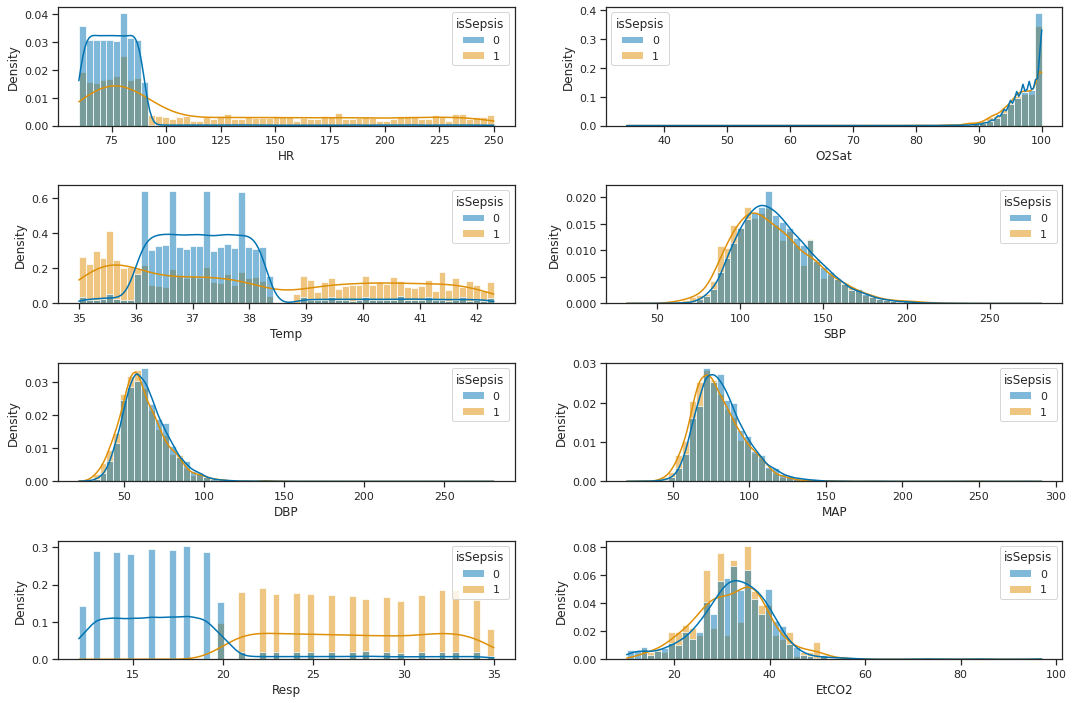

In [20]:
sns.set_theme(context="notebook", style="ticks", palette="colorblind")
plt.figure(figsize=(18,12))
plt.subplots_adjust(hspace = .5)
for i, column in enumerate(vitals, 1):
    plt.subplot(4,2,i)
    # stat = Aggregate statistic to compute in each bin density normalizes counts so that the area of the histogram is 1
    # common_norm = False = normalize each histogram independently
    # kde = If True, compute a kernel density estimate to smooth the distribution and show on the plot as (one or more) line(s)
    sns.histplot(data=X_train, x=column, hue=y_train, stat="density", common_norm=False, bins=60, kde=True)

Observations
1. HR, Temp, MAP, Resp all have clear separation between Septic and non-Septic patients
1. SBP and DBP are used to calculate MAP, could drop
1. no clear pattern in O2Sat and EtCO2

Is there correlation between signals?

<AxesSubplot:>

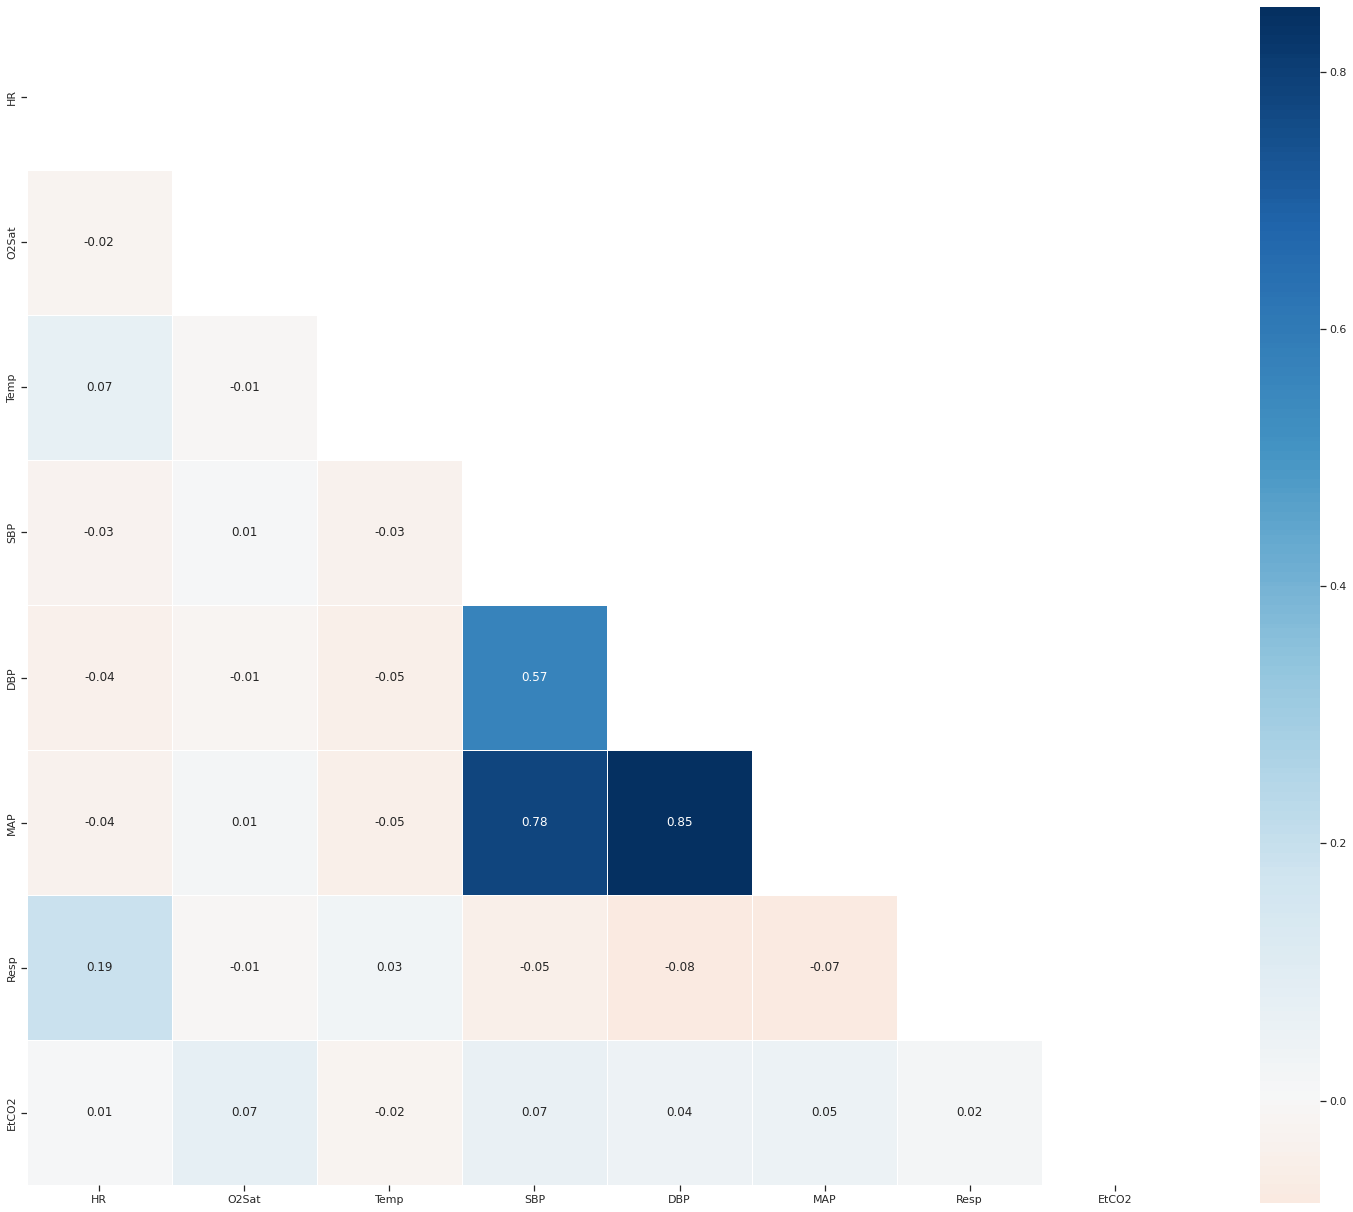

In [21]:
corr_features = [
               # vitals
               "HR", # Heart Rate normal adult 60 - 100 beats per minute (bpm)
               "O2Sat", # Oxygen saturation normal adult 97% - 100% (%)
               "Temp", # Temperature normal 97.8°F/36.5°C - 99°F/37.2°C (°C)
               "SBP", # Systolic Blood Pressure normal < 120 mmHg (mm Hg)
               "DBP", # beclomethasone dipropionate normal < 80 mmHg (mm Hg)
               "MAP", # Mean Arterial Pressure (mm Hg)
               "Resp", # Respiration rate  12<normal<20 breaths / minute (bpm)
               "EtCO2", # End-tidal CO2 maximum concentration of CO2 at exhalation normal 35 - 45 mmHg (mm Hg) = REMOVED missing too much data
            ]
corr_matrix = data[corr_features].corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(26,22))
sns.heatmap(corr_matrix, mask=mask, square=True, annot=True, fmt=".2f", center=0, linewidths=.5, cmap="RdBu")

In [ ]:
Observations
1. DBP and SBP are used to calculate MAP, so they are highly correlated

Another view is correlation against the label:

In [22]:
corr_matrix = data.corr()
corr_matrix["isSepsis"].sort_values(ascending=False)

isSepsis       1.000000
Resp           0.512989
HR             0.417939
Temp           0.138484
EtCO2         -0.005394
SBP           -0.027312
DBP           -0.043104
MAP           -0.045914
patient_id    -0.049953
O2Sat         -0.050067
record_date         NaN
record_time         NaN
Name: isSepsis, dtype: float64

Observation
1. Resp, HR, and Temp are highly correlated to Septic patients

Reference List:
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6304323/
- https://www.aafp.org/afp/2013/0701/p44.html
- https://www.kaggle.com/maxskoryk/datasepsis
- https://www.nursingcenter.com/ncblog/march-2017/elevated-lactate-%E2%80%93-not-just-a-marker-for-sepsis-an
- https://unitslab.com/node/74